In [44]:
import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
import copy
import random
import os
from lenstronomy.Util import util
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.lens_plot import lens_model_plot
import lenstronomy.Plots.plot_util as plot_util

In [48]:
# Settings for DES Camera
DES_camera = {'read_noise': 7.,  # stdev of noise from read-out (e)
               'pixel_scale': 0.2637,  # deltaPix
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital)
              }

# g, r, and i filters
DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (s)
                   'sky_brightness': 35.01,  # sky brightness (mag/arcsec^2)
                   'magnitude_zero_point': 30,  # magnitude where 1 count/s/arcsec^2(ADU's)
                   'num_exposures': 7,  # number of combined exposures
                   'seeing': 1.12,  # fwhm of the PSF
                   'psf_type': 'GAUSSIAN'  # gaussian estimate of psf
                 }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN' 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN' 
                  }

# merge camera and filters
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

In [73]:
def simulation(ra_source, dec_source, theta_E, lens_model):
    numPix = 45  # number of pixels per axis
    deltaPix = 0.2637  # pixel size in arcsec
    kwargs_numerics = {'point_source_supersampling_factor': 10}

    # set lens model:
    if lens_model == 'SIE':  # singular isothermal sphere
        # define lens model:
        kwargs_lens = [{'theta_E': theta_E,
                        'e1': 0.1, 'e2': -0.2,
                        'center_x': 0, 'center_y': 0}]
        # kwargs_lens.append({'gamma1': , 'gamma2': }) for shear

        lens_model_list = ['SIE']  # add 'SHEAR' here if wanted

        # define 'matching' light model:
        light_model = ['SERSIC_ELLIPSE']  # elliptical light to match mass
        light_model_class = LightModel(light_model_list=light_model)

        # lens light
        kwargs_lens_light_mag_g = [{'magnitude': 18,
                                    'R_sersic': 0.1, 'n_sersic': 2,
                                    'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0, 'center_y': 0}]

        # source light
        kwargs_source_mag_g = [{'magnitude': 20,
                                'R_sersic': 0.1, 'n_sersic': 1,
                                'e1': 0.2, 'e2': -0.3,
                                'center_x': ra_source, 'center_y': dec_source}]

        # point source light
        kwargs_ps_mag_g = [{'magnitude': 21,
                            'ra_source': ra_source, 'dec_source': dec_source}]

    elif lens_model == 'SIS':
        # lens model:
        kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]
        lens_model_list = ['SIS']

        # light model:
        light_model = ['SERSIC']  # non-elliptical
        light_model_class = LightModel(light_model_list=light_model)

        kwargs_lens_light_mag_g = [{'magnitude': 17,
                                    'R_sersic': 0.6, 'n_sersic': 4,
                                    'center_x': 0, 'center_y': 0}]

        kwargs_source_mag_g = [{'magnitude': 20,
                                'R_sersic': 0.3, 'n_sersic': 1,
                                'center_x': ra_source, 'center_y': dec_source}]

        kwargs_ps_mag_g = [{'magnitude': 21,
                            'ra_source': ra_source, 'dec_source': dec_source}]

    elif lens_model == 'SPEP':  # Softened Power-law Elliptical Potential
        # lens model:
        kwargs_lens = [{'theta_E': theta_E, 'gamma': 0.1,
                        'e1': 0.1, 'e2': -0.2,
                        'center_x': 0, 'center_y': 0}]

        lens_model_list = ['SPEP']

        # light model:
        light_model = ['SERSIC_ELLIPSE']  # elliptical
        light_model_class = LightModel(light_model_list=light_model)

        kwargs_lens_light_mag_g = [{'magnitude': 16,
                                    'R_sersic': 0.1, 'n_sersic': 2,
                                    'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0, 'center_y': 0}]

        kwargs_source_mag_g = [{'magnitude': 19,
                                'R_sersic': 0.1, 'n_sersic': 1,
                                'e1': 0.1, 'e2': -0.1,
                                'center_x': ra_source, 'center_y': dec_source}]

        kwargs_ps_mag_g = [{'magnitude': 20,
                            'ra_source': ra_source, 'dec_source': dec_source}]

    elif lens_model == 'EPL':  # Elliptical Power-Law
        # lens model:
        kwargs_lens = [{'theta_E': theta_E, 'gamma': 0.01,
                        'e1': 0.1, 'e2': -0.2,
                        'center_x': 0, 'center_y': 0}]

        lens_model_list = ['EPL']

        # light model:
        light_model = ['SERSIC_ELLIPSE']
        light_model_class = LightModel(light_model_list=light_model)

        kwargs_lens_light_mag_g = [{'magnitude': 17,
                                    'R_sersic': 0.1, 'n_sersic': 2,
                                    'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0, 'center_y': 0}]

        kwargs_source_mag_g = [{'magnitude': 20,
                                'R_sersic': 0.1, 'n_sersic': 1,
                                'e1': 0.2, 'e2': -0.3,
                                'center_x': ra_source, 'center_y': dec_source}]

        kwargs_ps_mag_g = [{'magnitude': 21,
                            'ra_source': ra_source, 'dec_source': dec_source}]

    else:
        print(f"{lens_model} not supported. Use 'SIE', 'SIS', 'SPEP' or 'EPL'")

    # Combine models:
    kwargs_model = {'lens_model_list': lens_model_list,  # lens mass
                    'lens_light_model_list': light_model,  # lens light
                    'source_light_model_list': light_model,  # extended source
                    'point_source_model_list': ['SOURCE_POSITION']}  # point source

    # Configurations for simulated image for g,r,i
    sim_g = SimAPI(numpix=numPix,
                   kwargs_single_band=kwargs_g_band,
                   kwargs_model=kwargs_model)

    sim_r = SimAPI(numpix=numPix,
                   kwargs_single_band=kwargs_r_band,
                   kwargs_model=kwargs_model)

    sim_i = SimAPI(numpix=numPix,
                   kwargs_single_band=kwargs_i_band,
                   kwargs_model=kwargs_model)

    # return ImageModel class with my configurations
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    # Define parameters for remaining two bands (R, I)
    # R-band
    g_r_source = 1  # color mag_g - mag_r for source
    g_r_lens = -1  # color mag_g - mag_r for lens light
    g_r_ps = 0  # color for point source
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens  # new magnitude

    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_r[0]['magnitude'] -= g_r_source

    kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
    kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps

    # i-band
    g_i_source = 2
    g_i_lens = -2
    g_i_ps = 0
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i[0]['magnitude'] -= g_i_source

    kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
    kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps

    # translate magnitude into amplitude
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)

    imgG = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    imgR = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    imgI = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # add noise to simulated image
    # imgG += sim_g.noise_for_model(model=image_g)
    # imgR += sim_r.noise_for_model(model=image_r)
    # imgI += sim_i.noise_for_model(model=image_i)

    # create final image
    img = np.zeros((numPix, numPix, 3), dtype=float)
    img[:, :, 0] = plot_util.sqrt(imgG, scale_min=0, scale_max=10000)
    img[:, :, 1] = plot_util.sqrt(imgR, scale_min=0, scale_max=10000)
    img[:, :, 2] = plot_util.sqrt(imgI, scale_min=0, scale_max=10000)

    # Lens Model Plot:
    lensModel = LensModel(lens_model_list=lens_model_list)

    # make coordinate grid
    x_grid, y_grid = util.make_grid(numPix=numPix, deltapix=deltaPix)
    x_grid = util.array2image(x_grid)
    y_grid = util.array2image(y_grid)

    kwargs_lens_plot = {'with_caustics': True,  # show critical curves & caustics
                        'fast_caustic': True,  # faster but less precise
                        'point_source': True,  # show image positions
                        'with_convergence': True,  # show convergence
                        'numPix': numPix, 'deltaPix': deltaPix}

    # Create Figure and Set Up Axes
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # ax[0]: lens model plot
    lens_model_plot(ax[0], lensModel, kwargs_lens,
                    sourcePos_x=ra_source,
                    sourcePos_y=dec_source,
                    **kwargs_lens_plot)

    ax[0].set_title('Critical curves and caustics', fontsize=20)

    # ax[1]: simulated image
    ax[1].set_title('Simulation', fontsize=20)
    ax[1].imshow(img, aspect='equal', origin='lower')


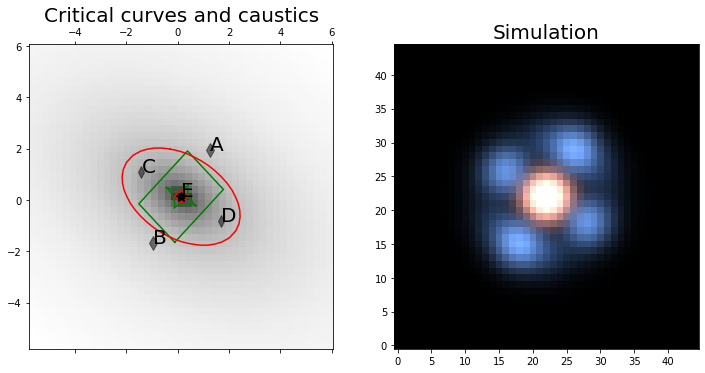

In [60]:
# test the function
simulation(0, 0, 2, 'SIE')

<ipython-input-73-133cf068d21a>:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))


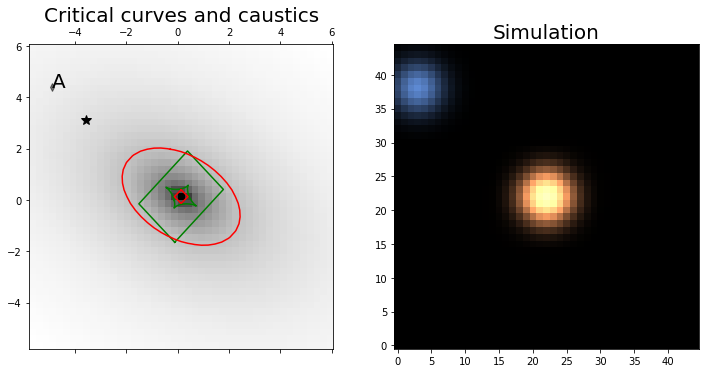

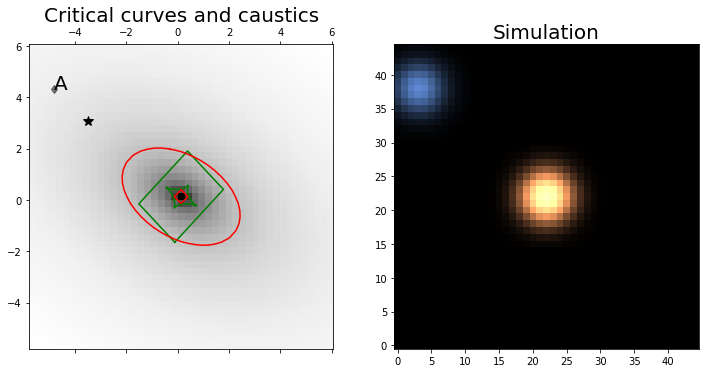

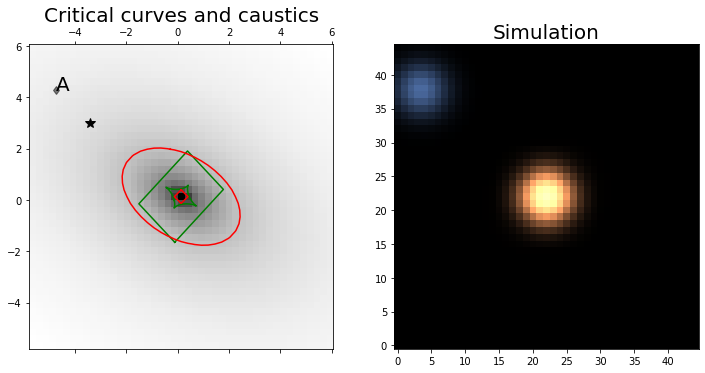

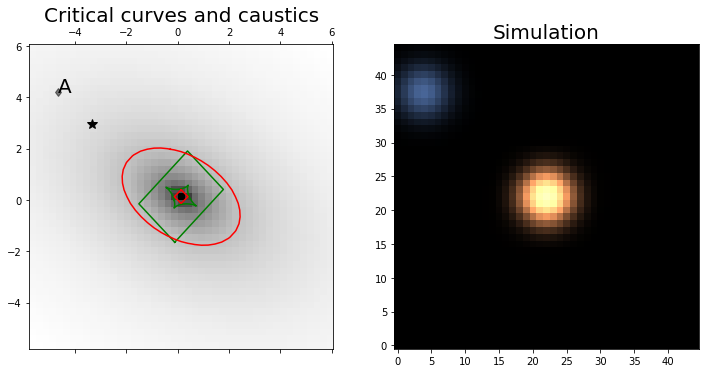

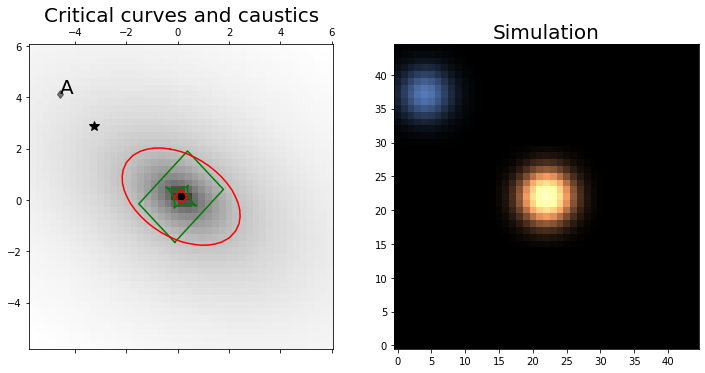

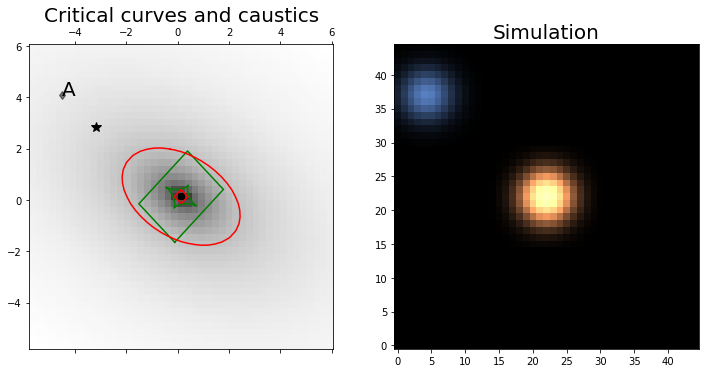

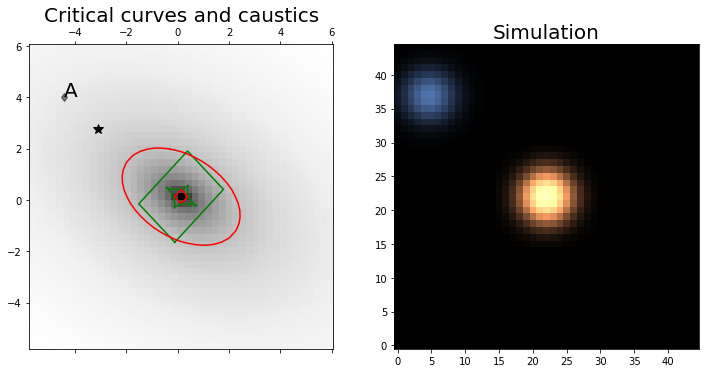

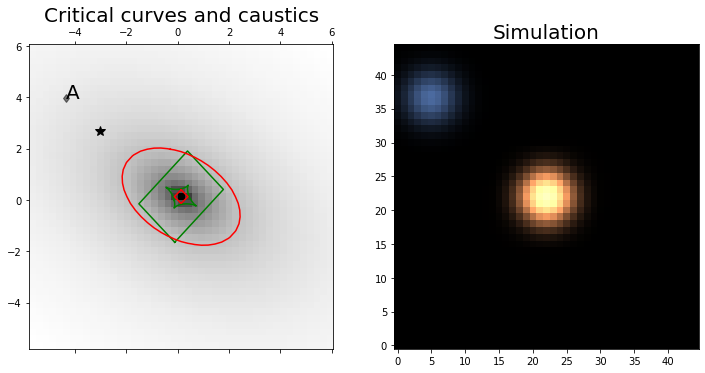

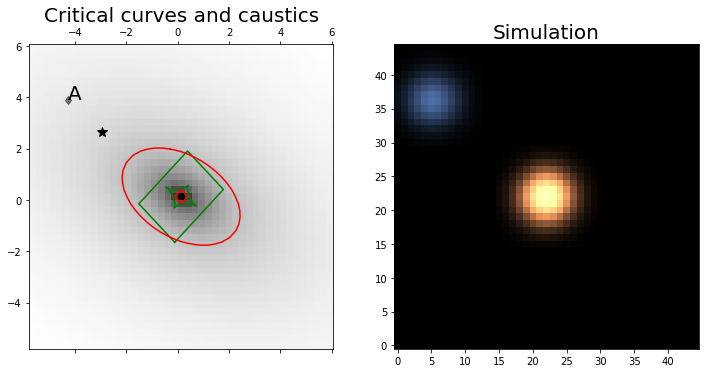

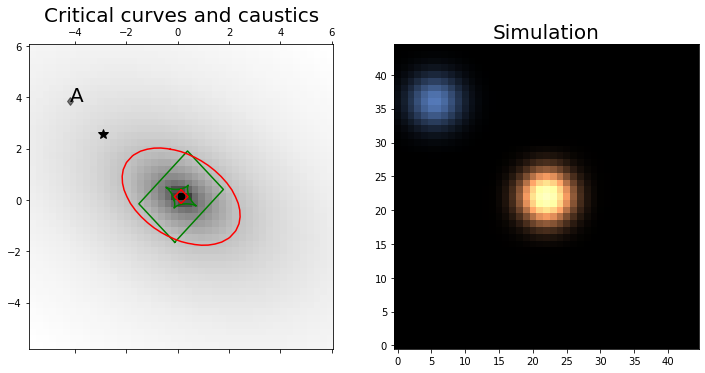

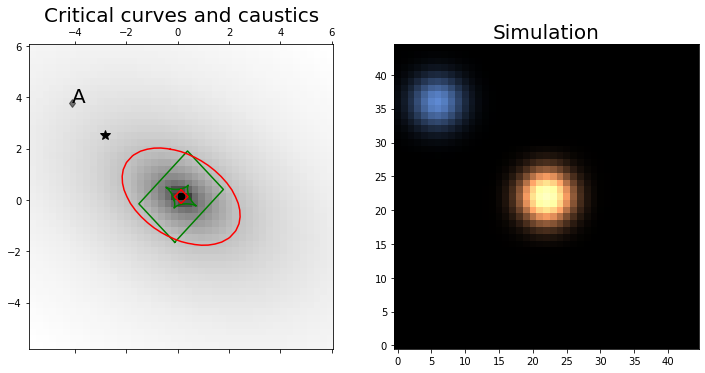

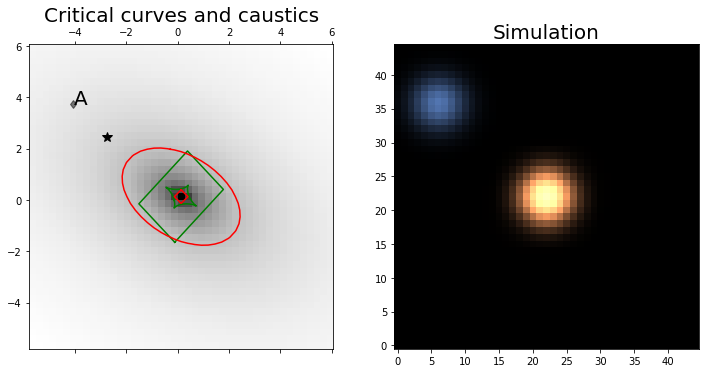

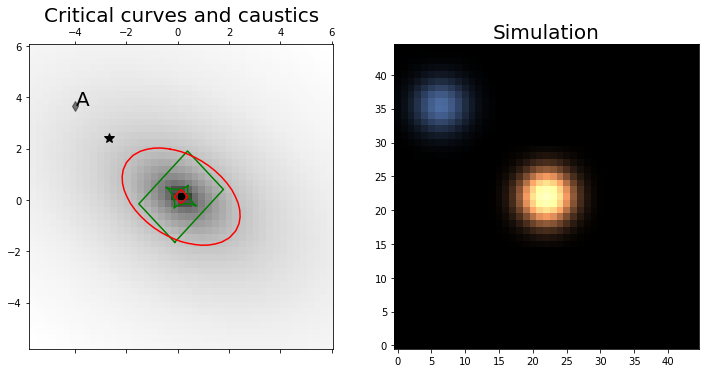

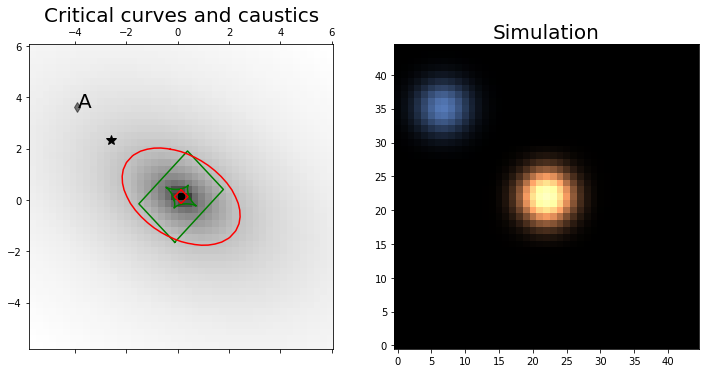

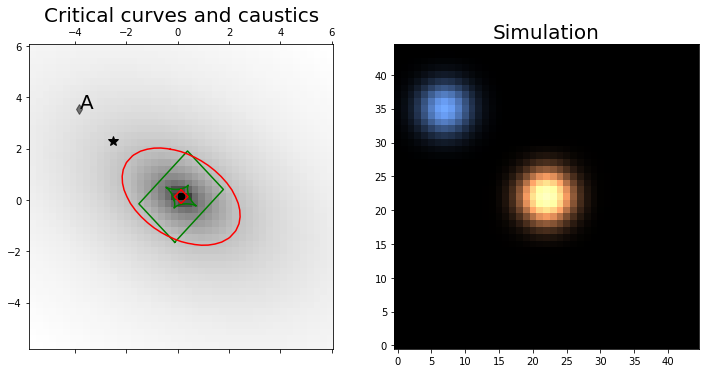

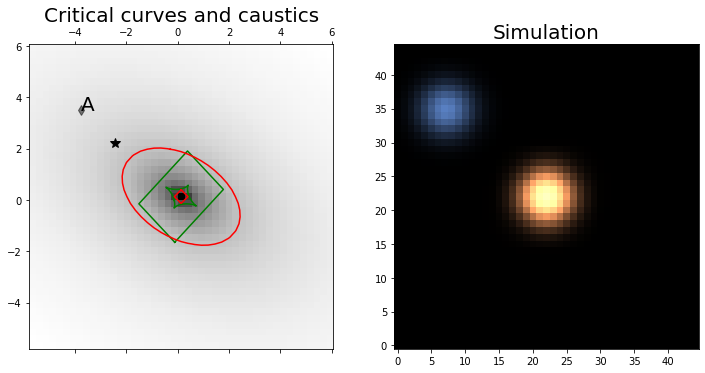

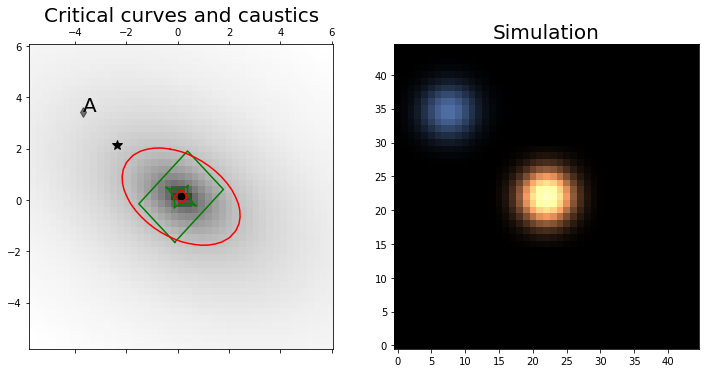

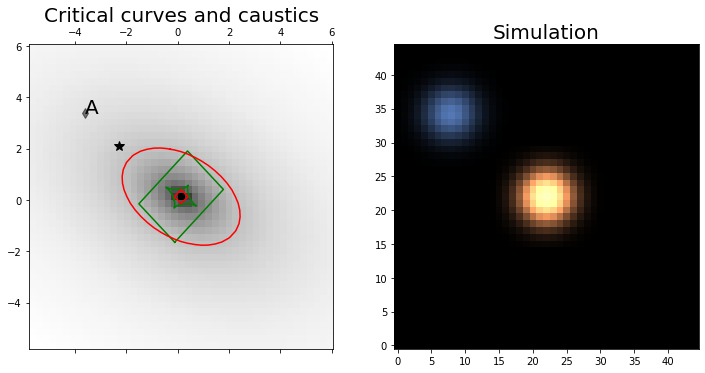

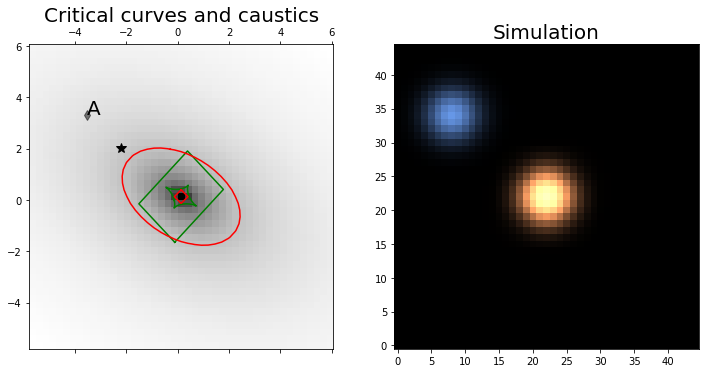

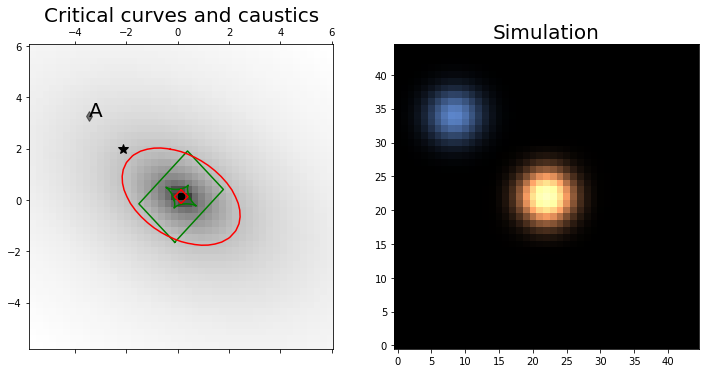

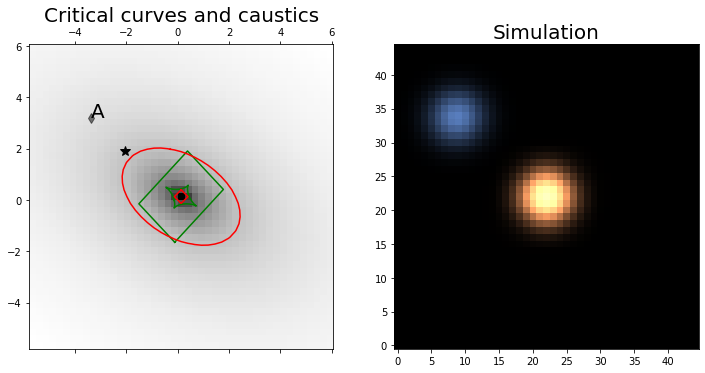

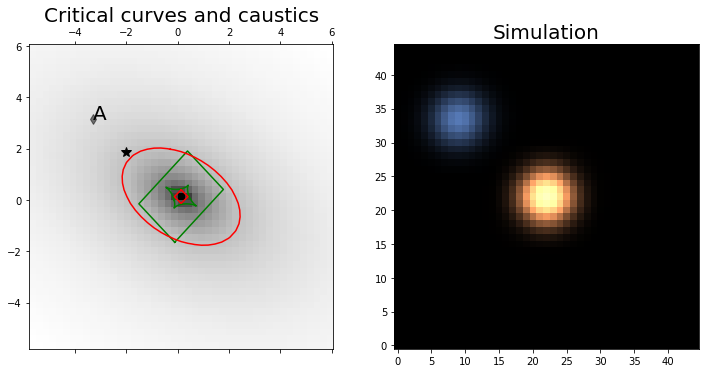

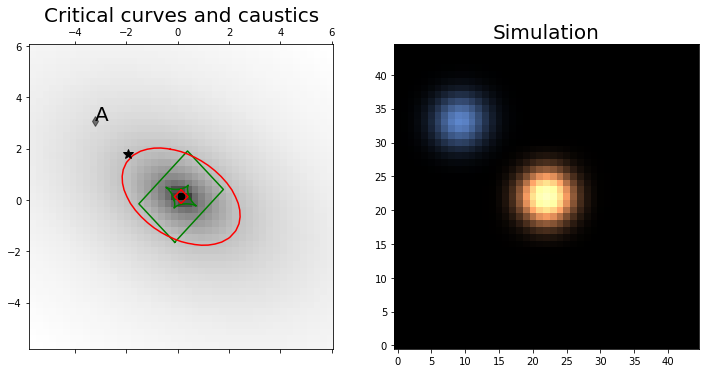

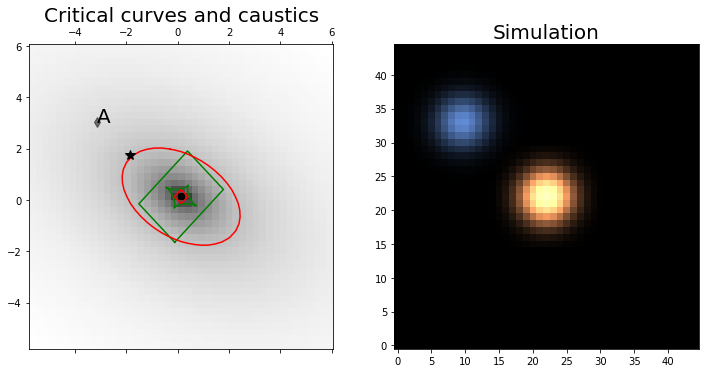

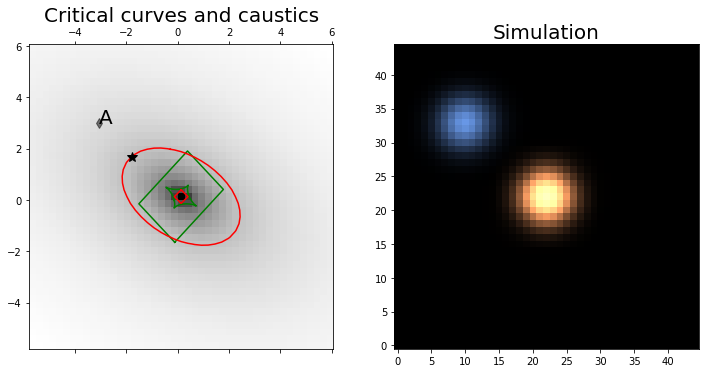

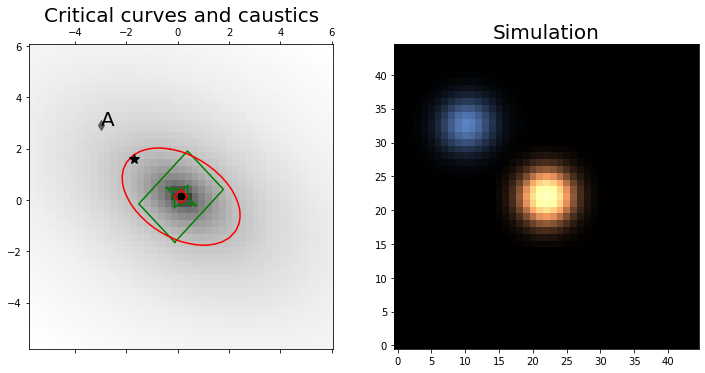

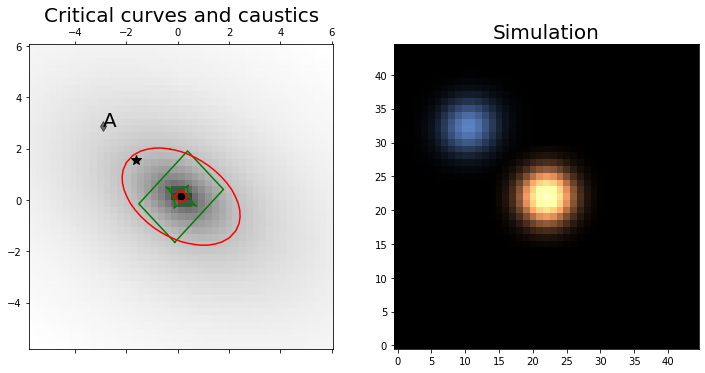

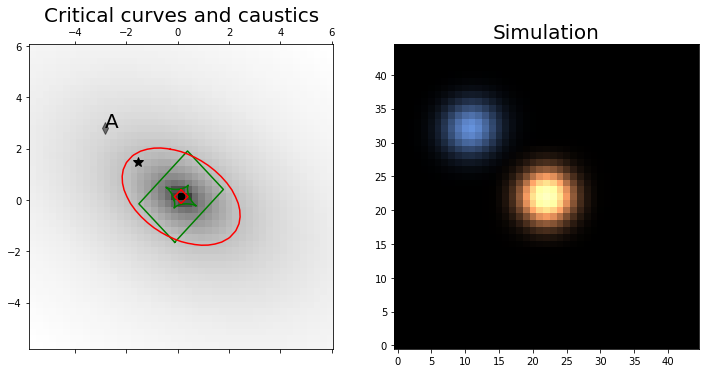

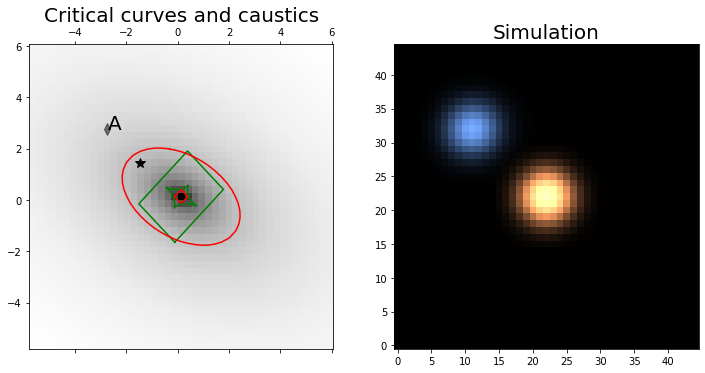

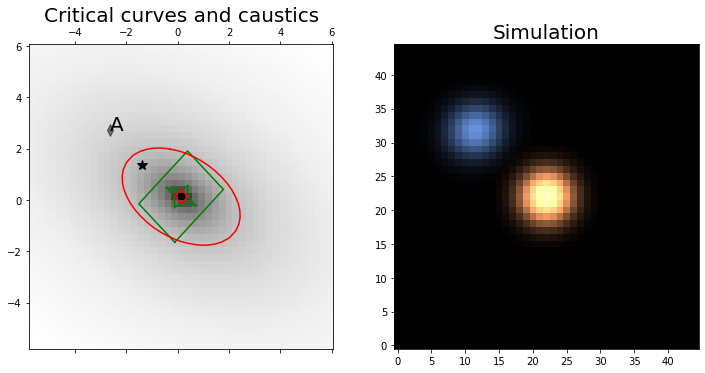

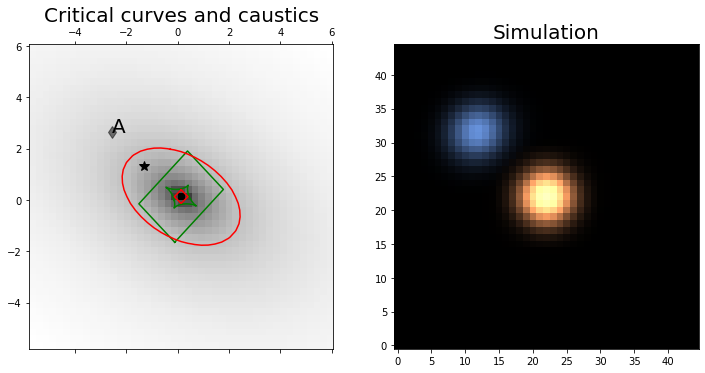

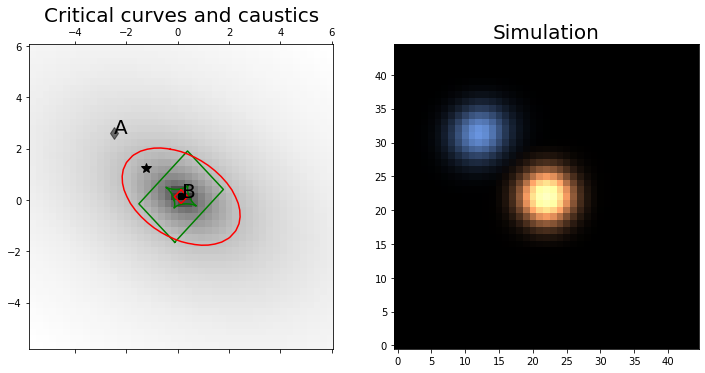

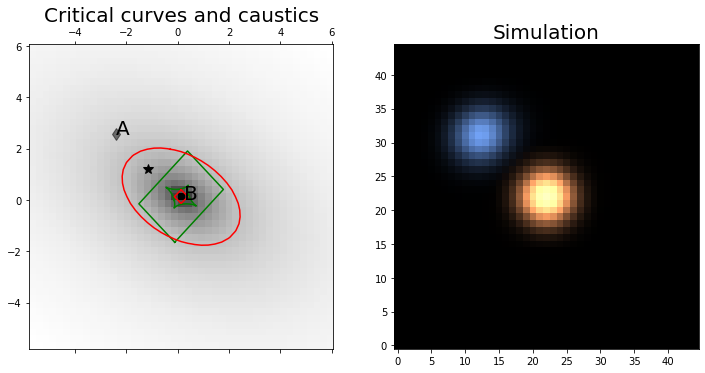

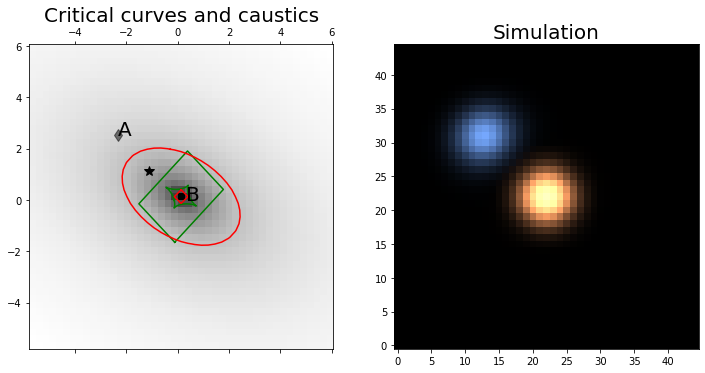

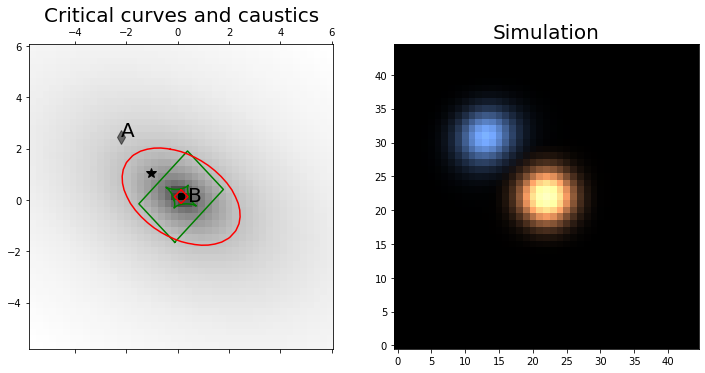

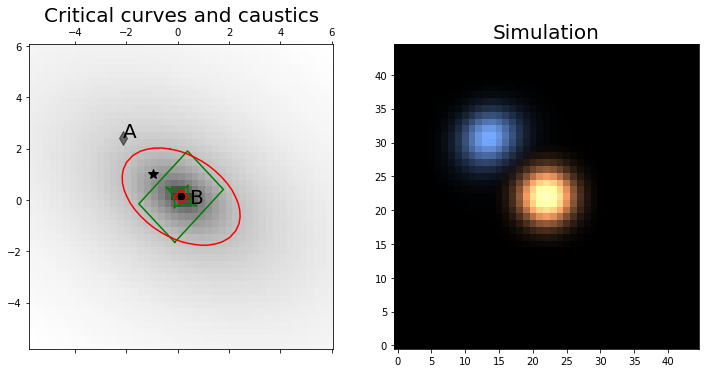

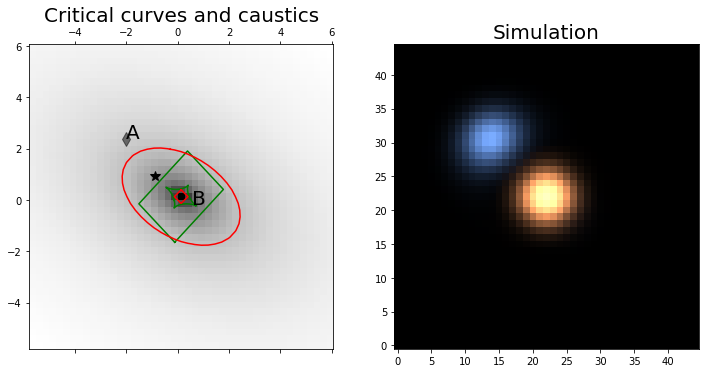

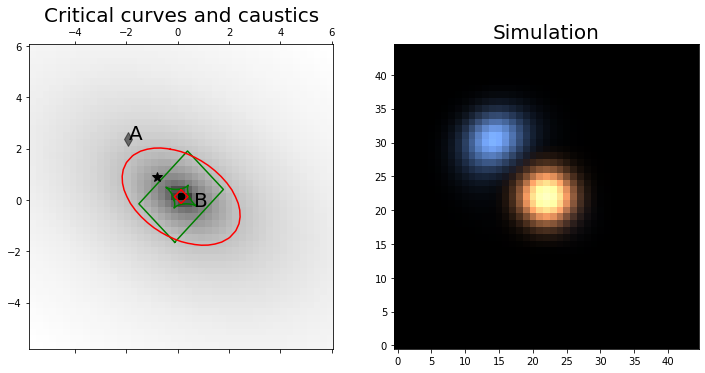

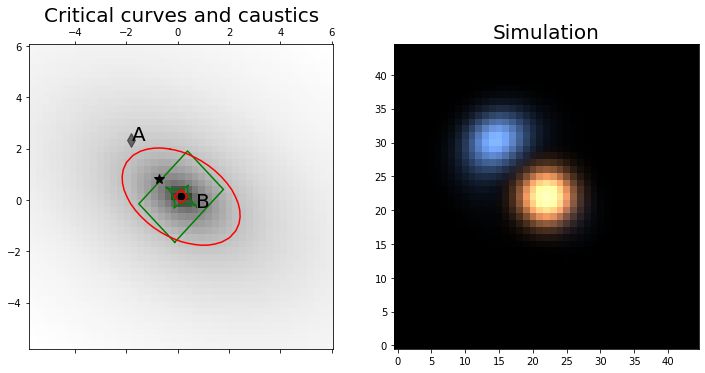

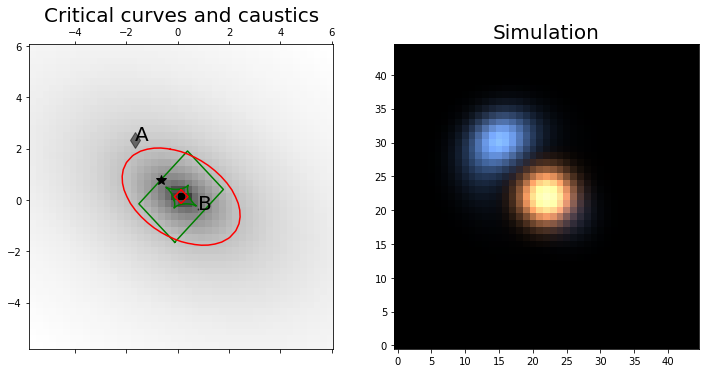

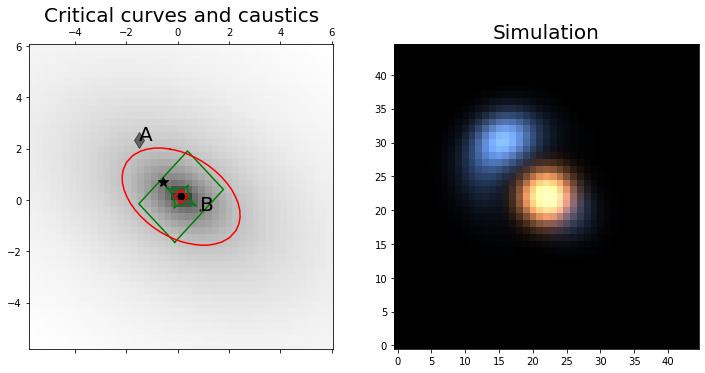

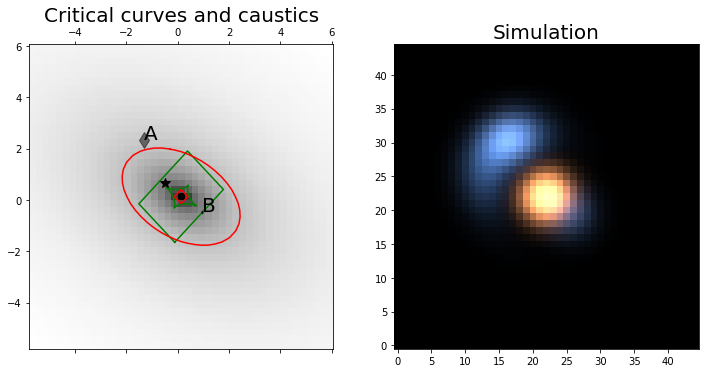

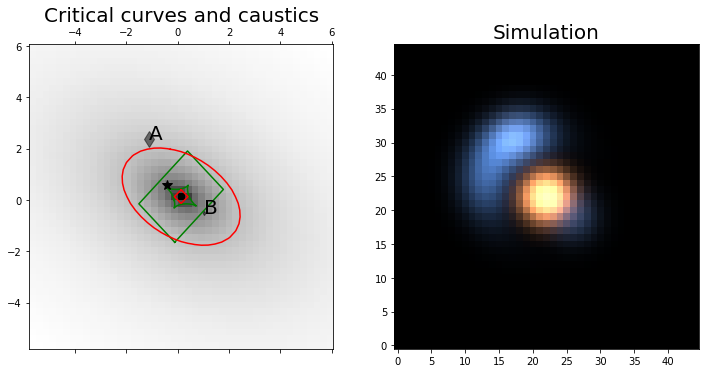

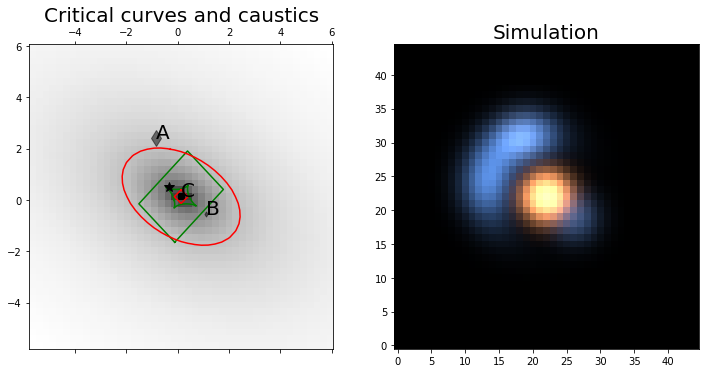

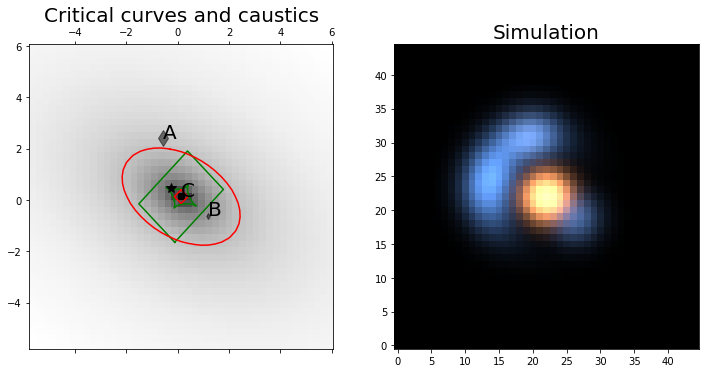

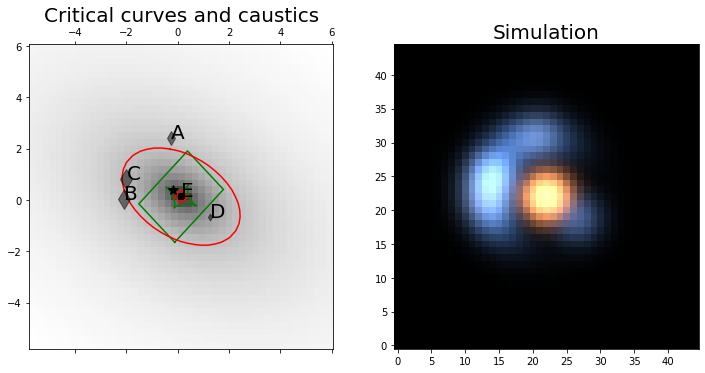

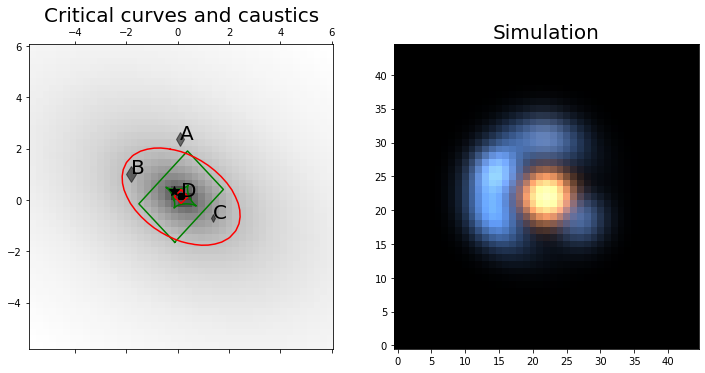

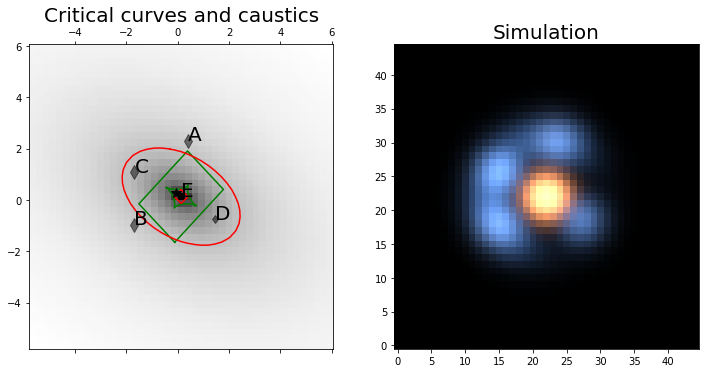

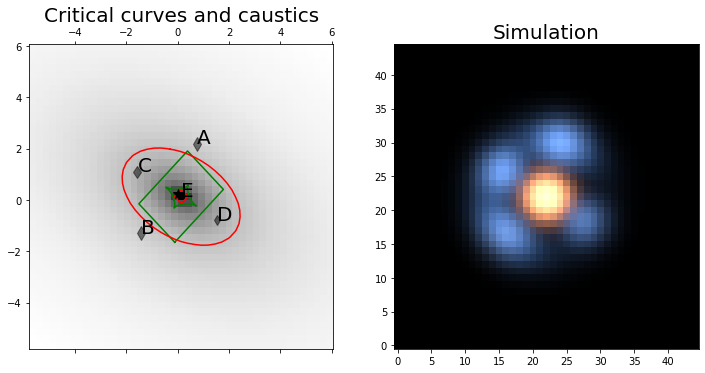

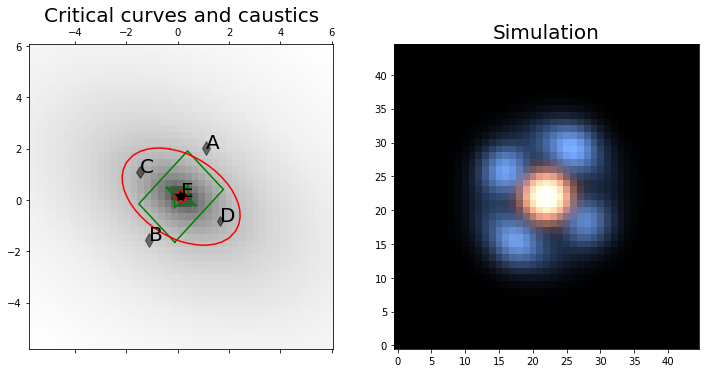

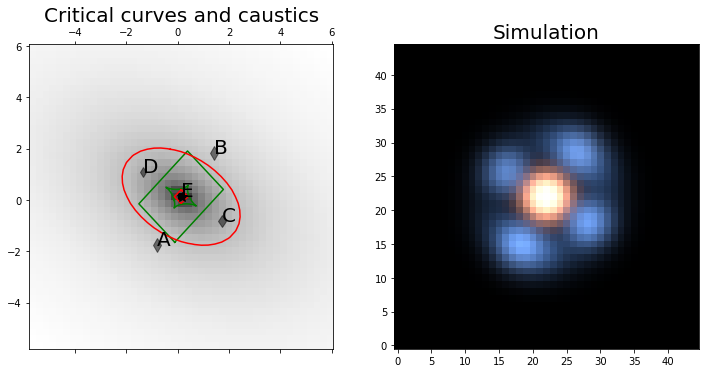

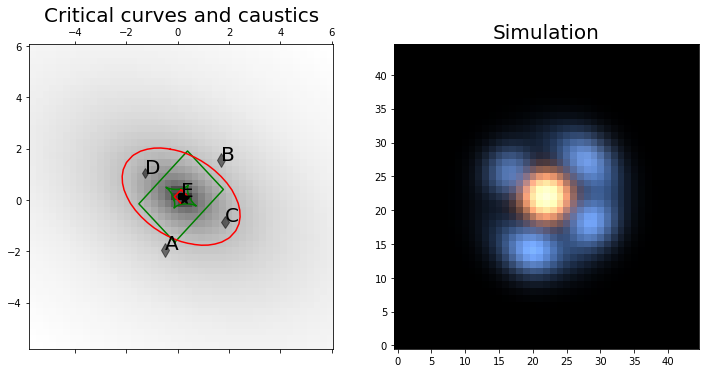

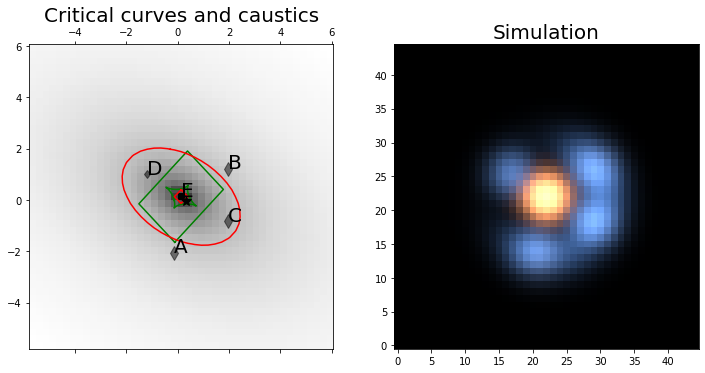

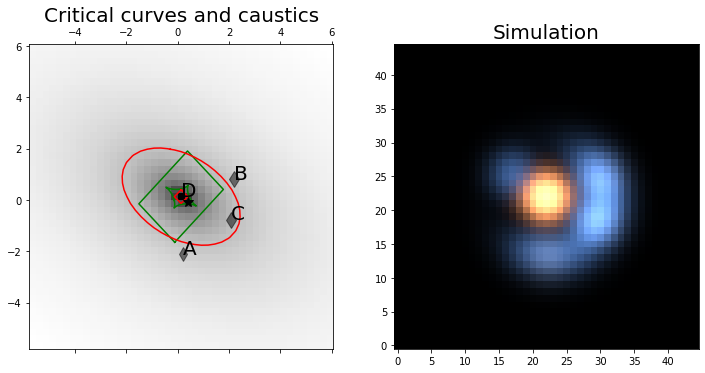

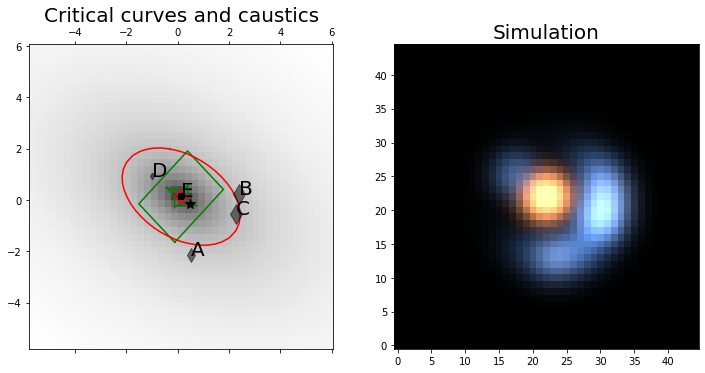

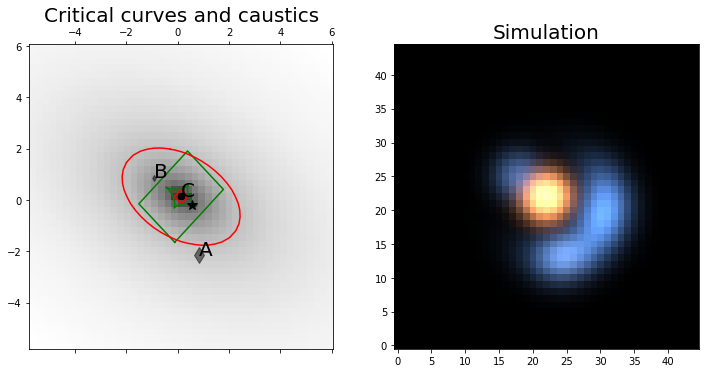

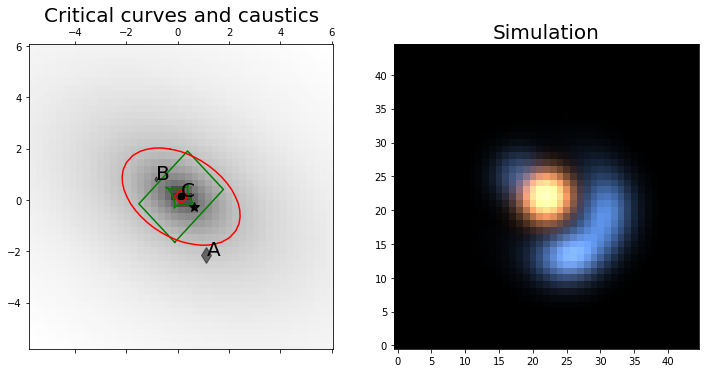

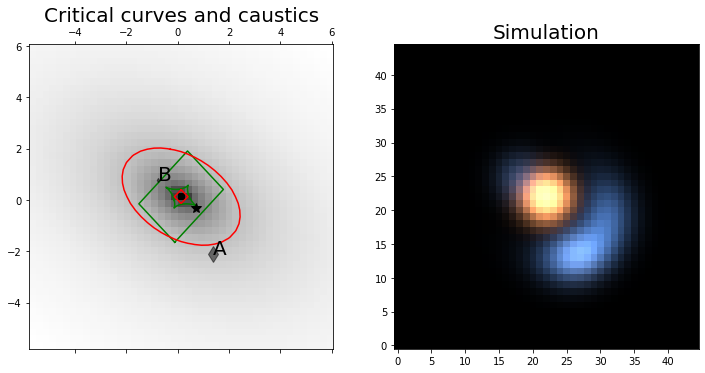

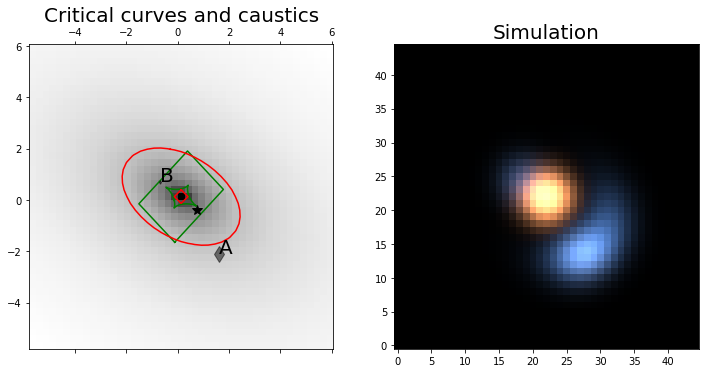

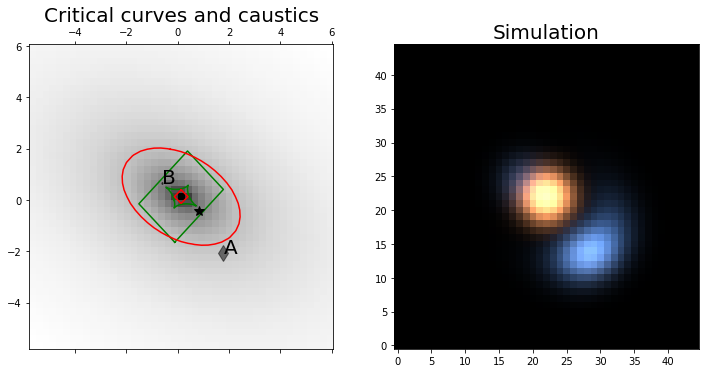

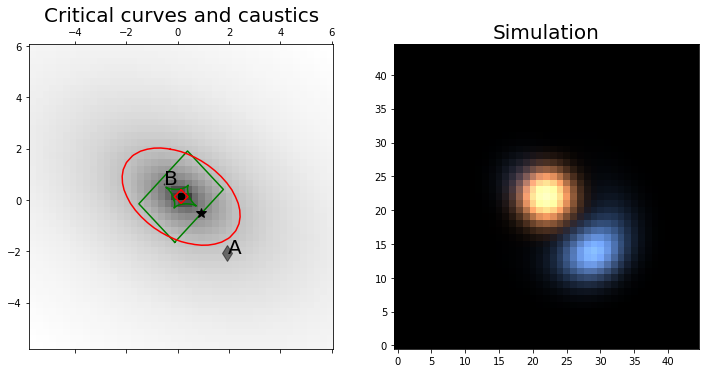

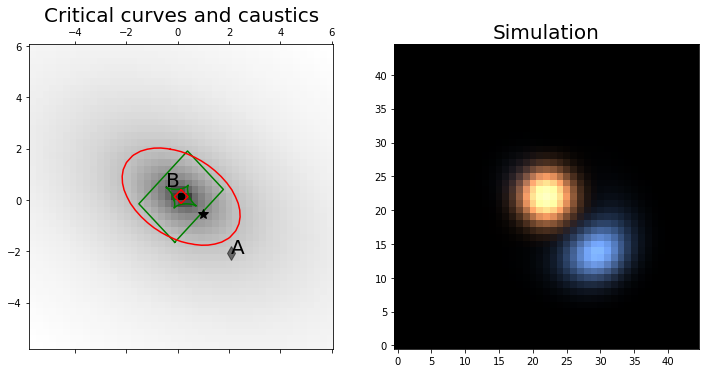

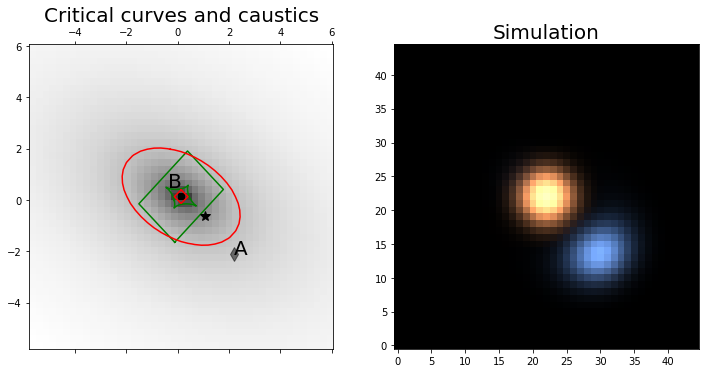

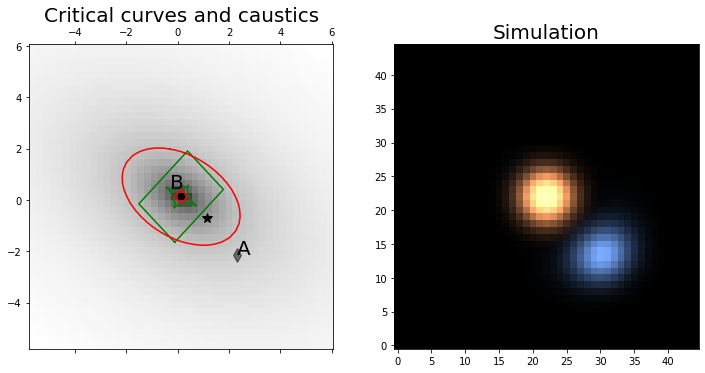

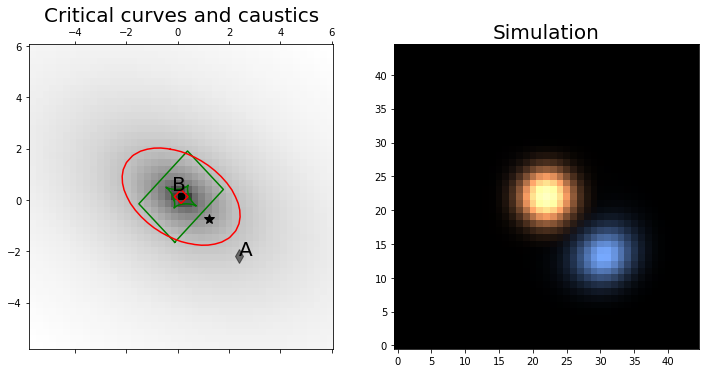

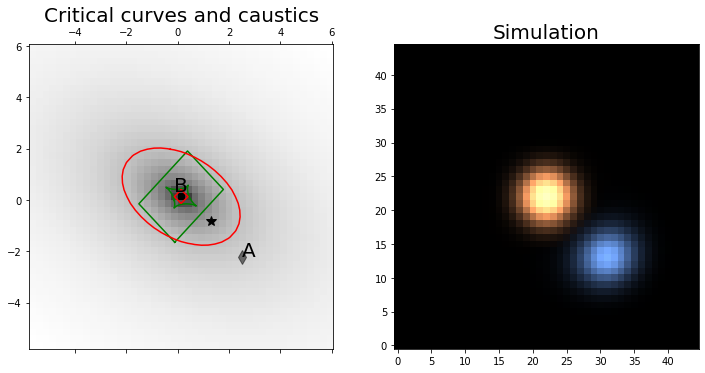

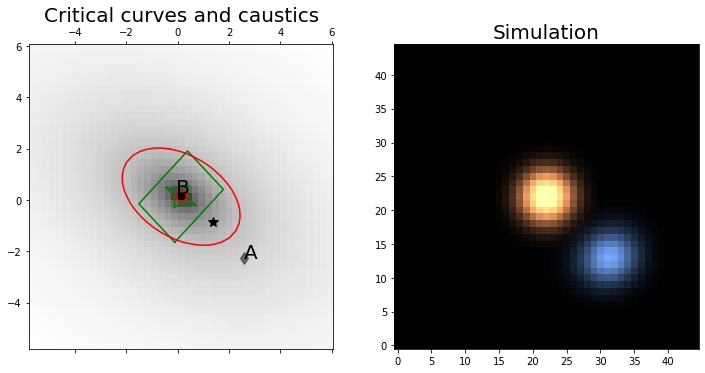

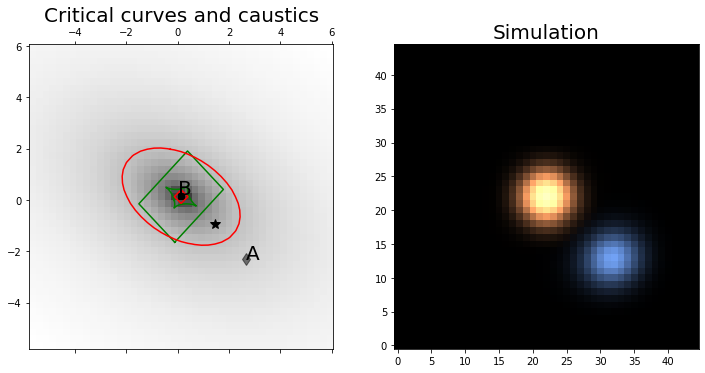

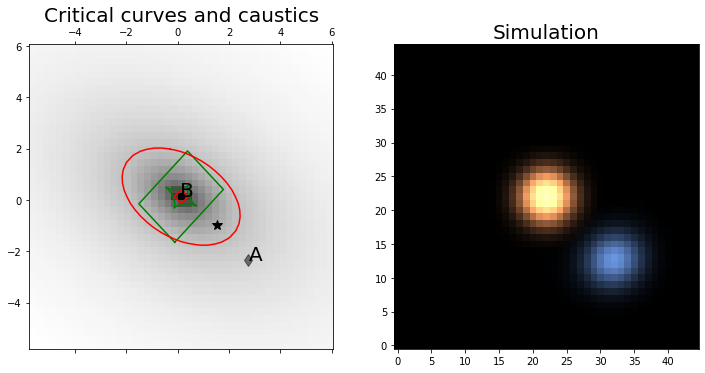

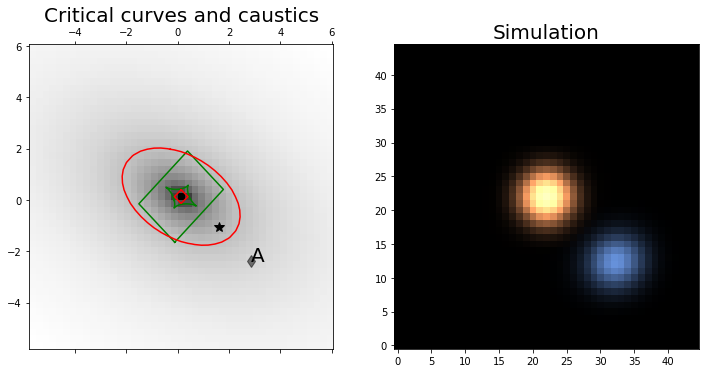

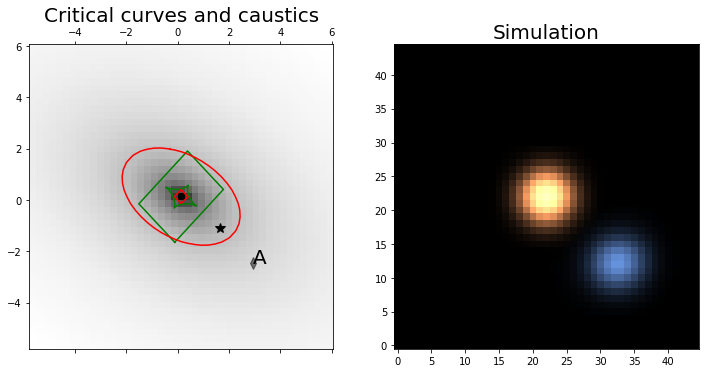

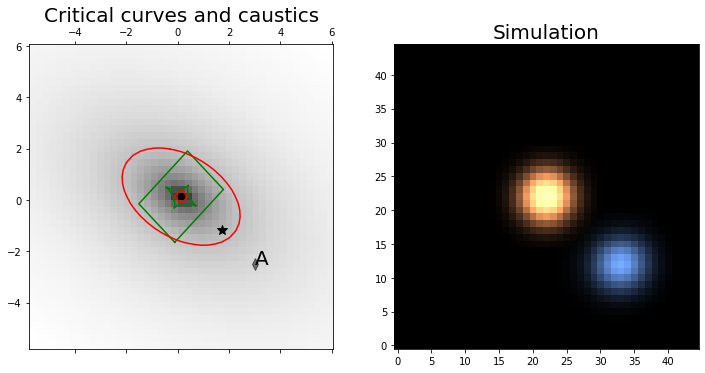

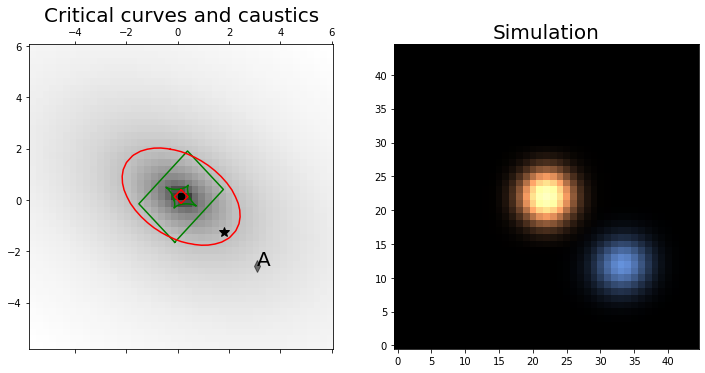

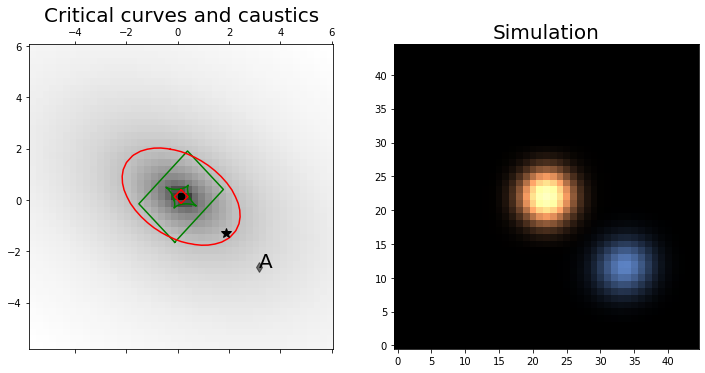

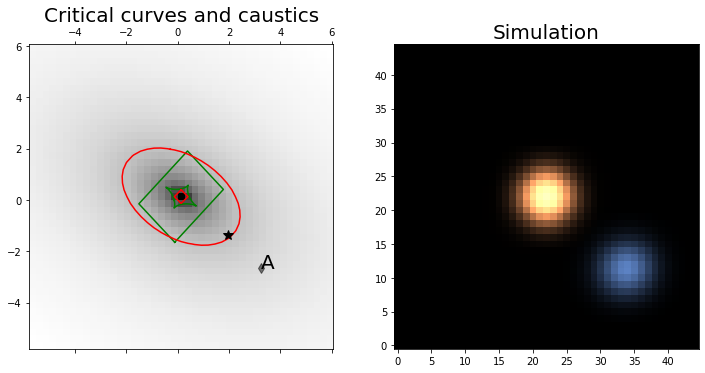

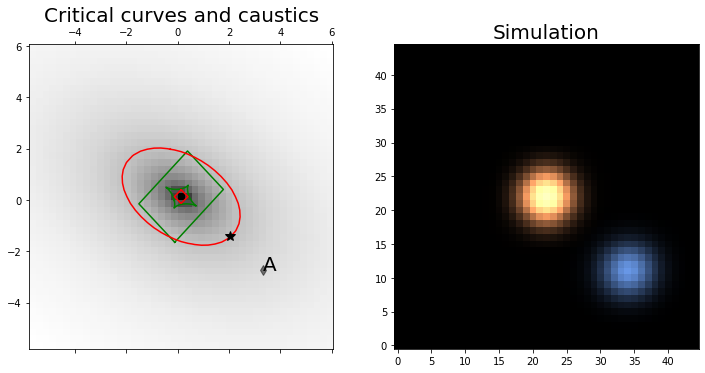

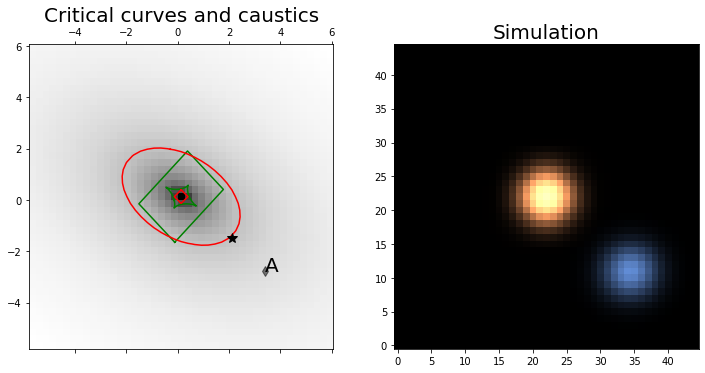

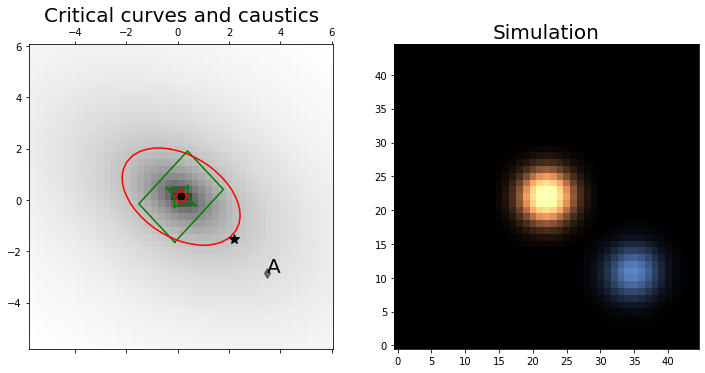

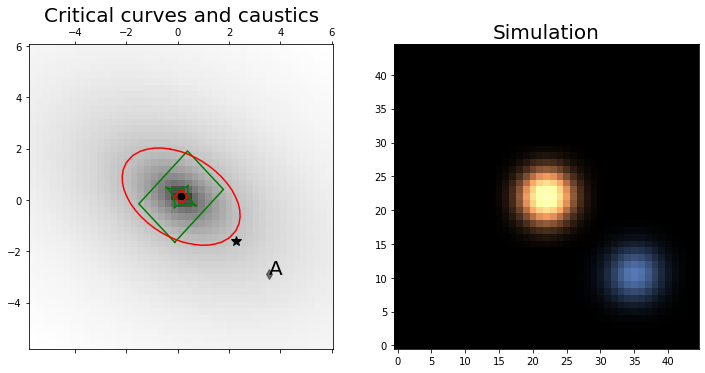

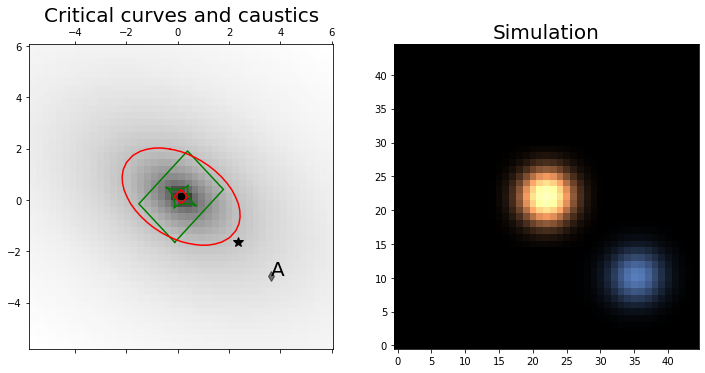

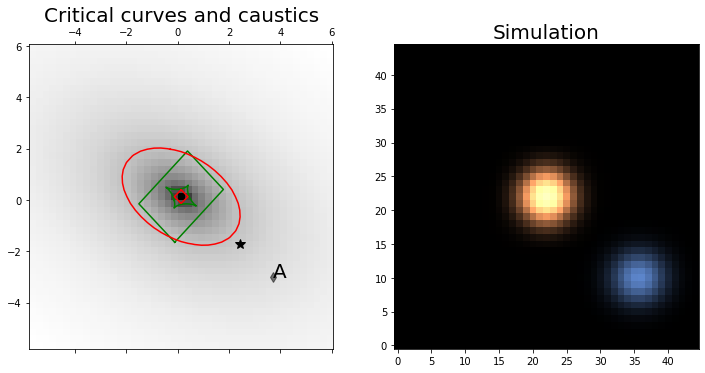

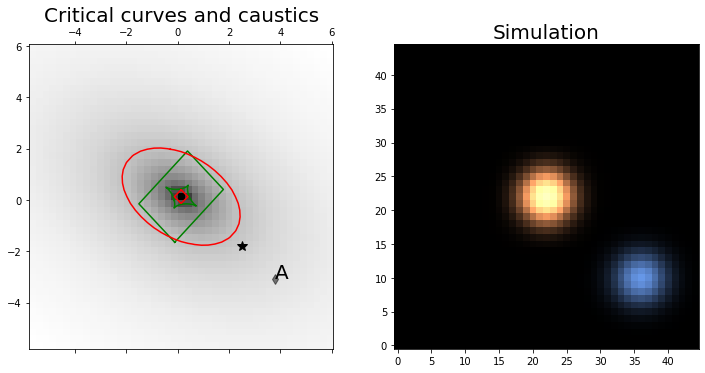

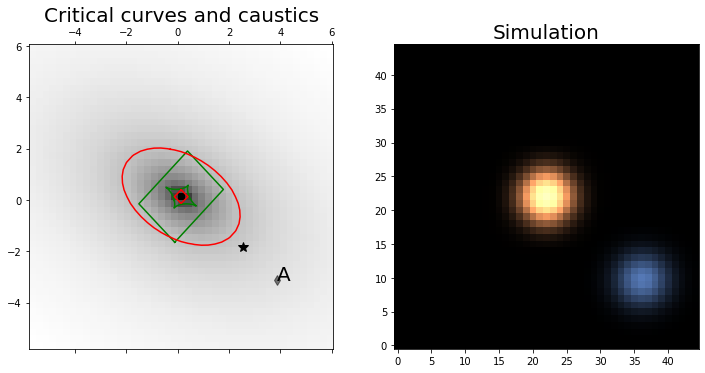

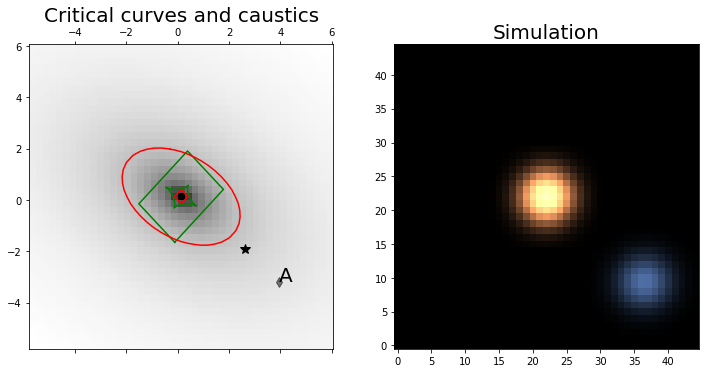

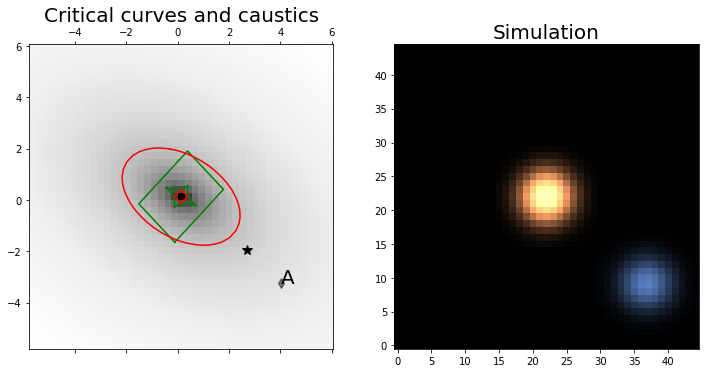

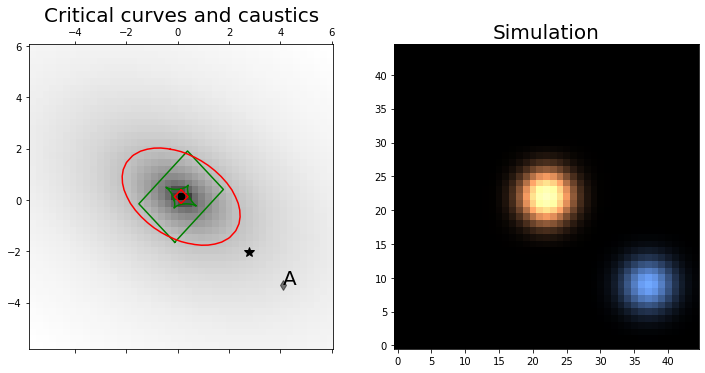

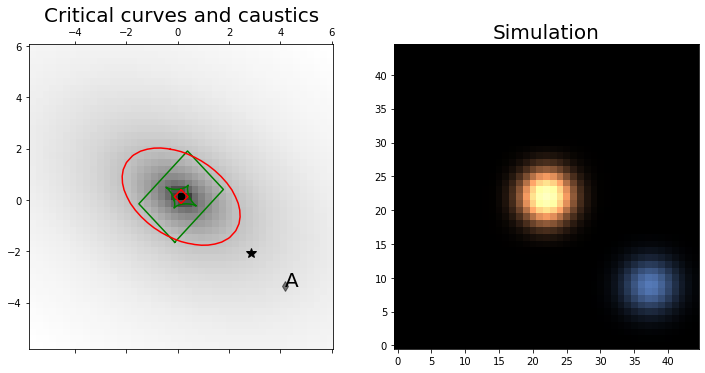

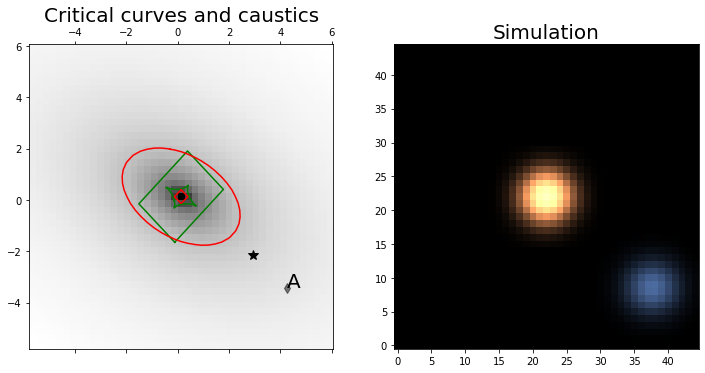

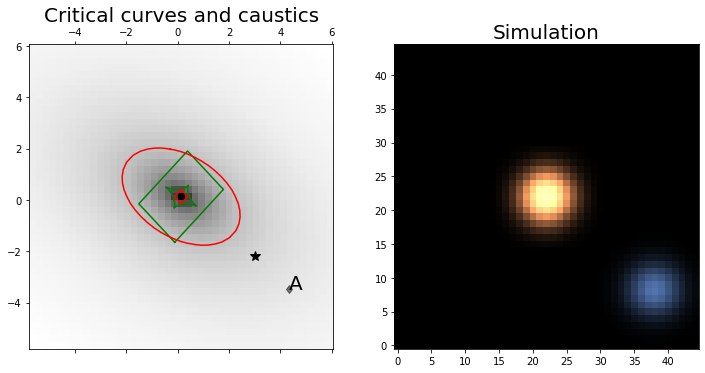

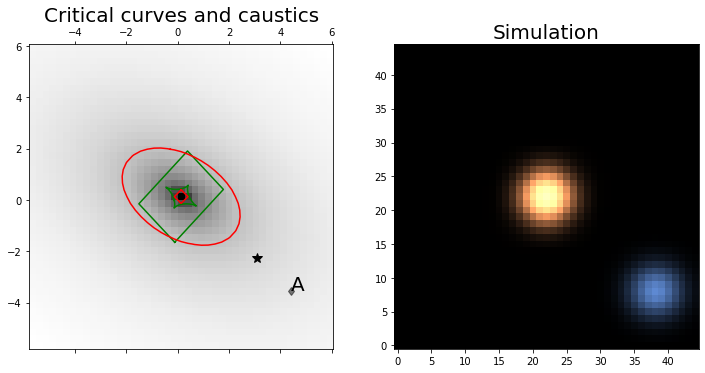

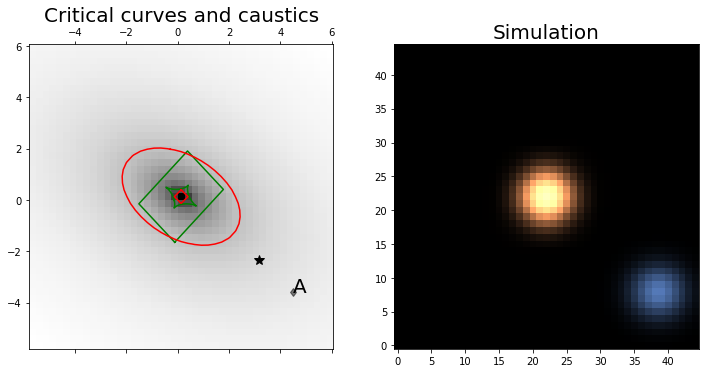

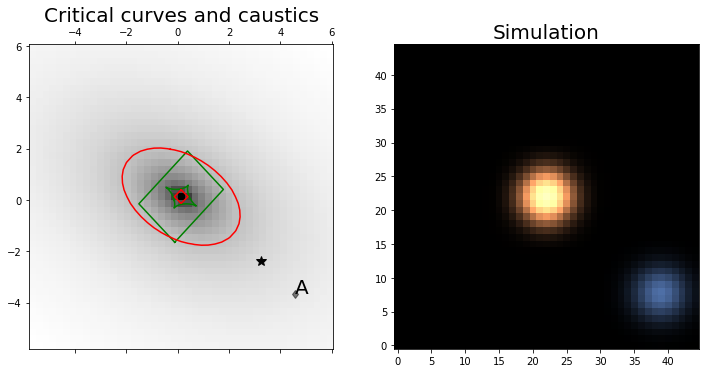

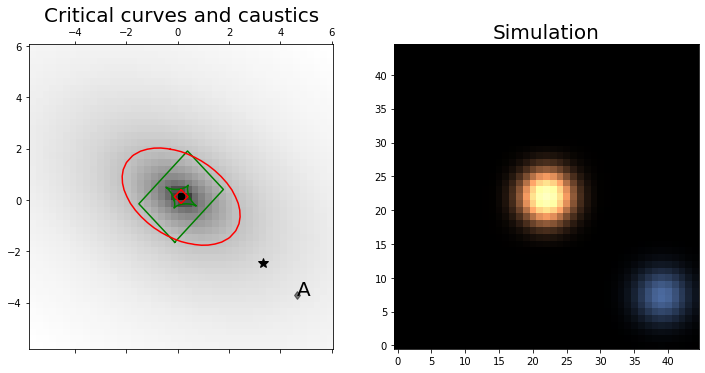

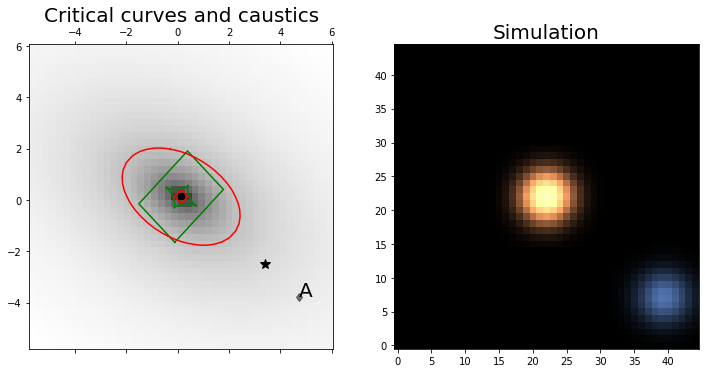

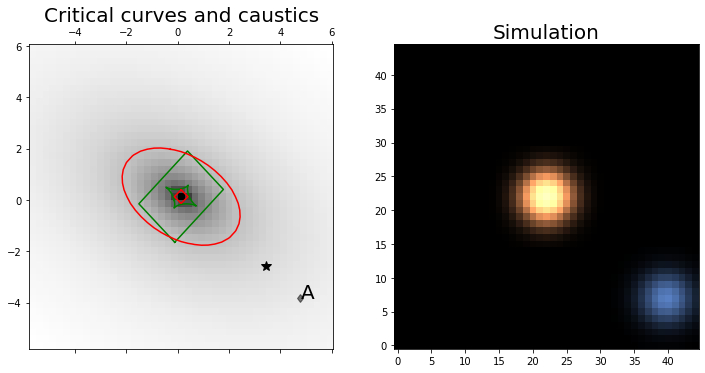

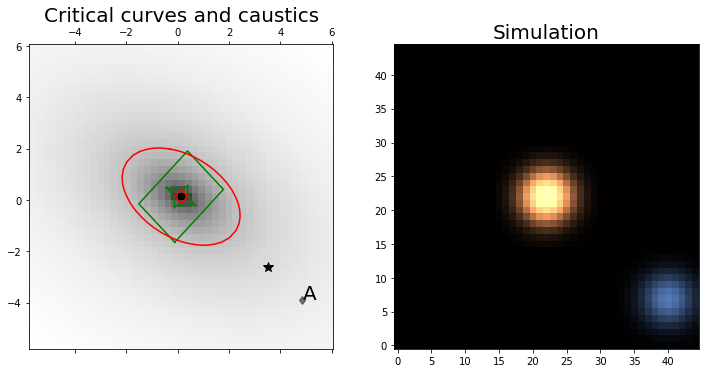

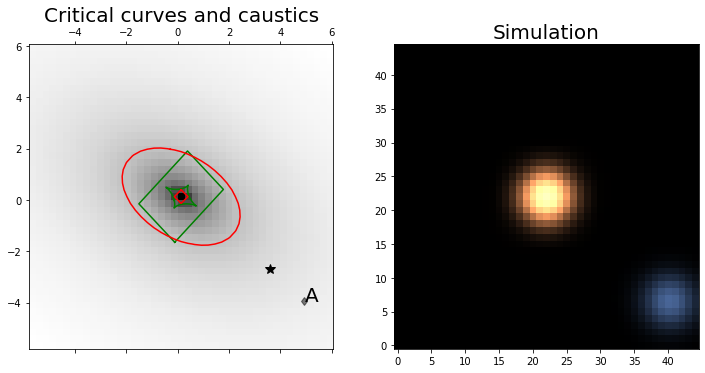

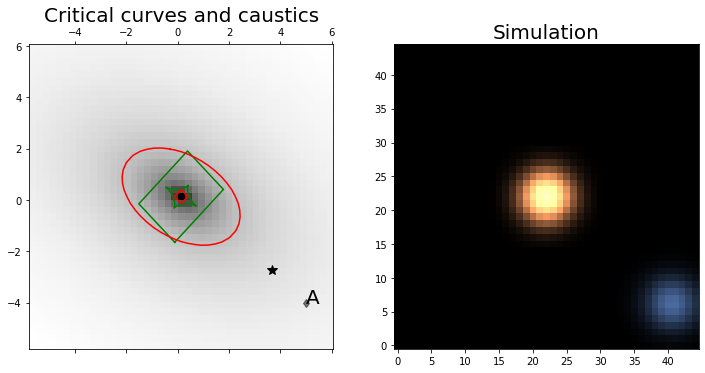

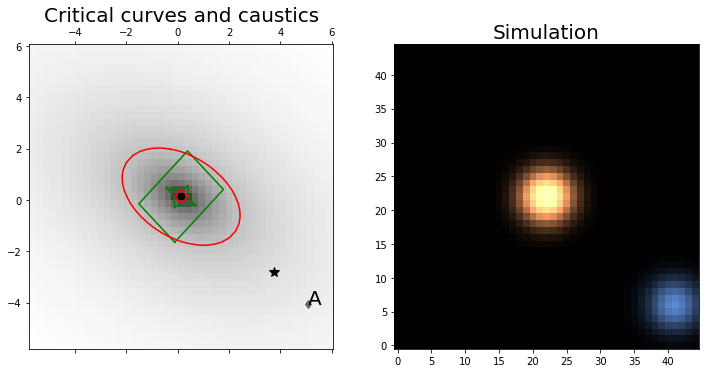

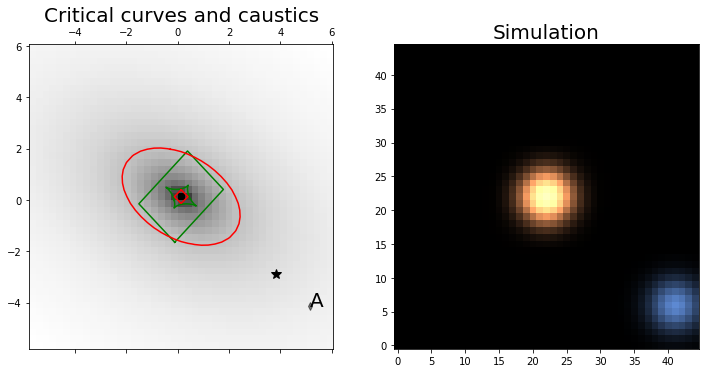

In [77]:
# create images
num_images = 100  # must be <= 100

# set bounds for ra_source and dec_source
ra_source_list = np.linspace(-3.7, 3.7, num_images)
dec_source_list = np.linspace(3, -3, num_images)

# system for naming that will keep files in proper order
numbers = np.arange(0, len(ra_source_list), 1)
naming = []
for num in numbers:
    padded = str(num).zfill(2)
    naming.append(padded)

# create and name images
for (ra, dec, name) in zip(ra_source_list, dec_source_list, naming):
    simulation(ra_source=ra, dec_source=dec, theta_E=2, lens_model='SIE')
    plt.savefig(str(name)+'.png', format='png')

In [78]:
# make GIF
make_gif = 'convert -delay 15 -loop 0 *.png testtrash.gif'
os.system(make_gif)

# delete images when finished
delete_images = 'rm *.png'
os.system(delete_images)
plt.close('all')

Notes:
* *delay*: speed between images in GIF
* if you want more than 100 images, change .zfill(3)